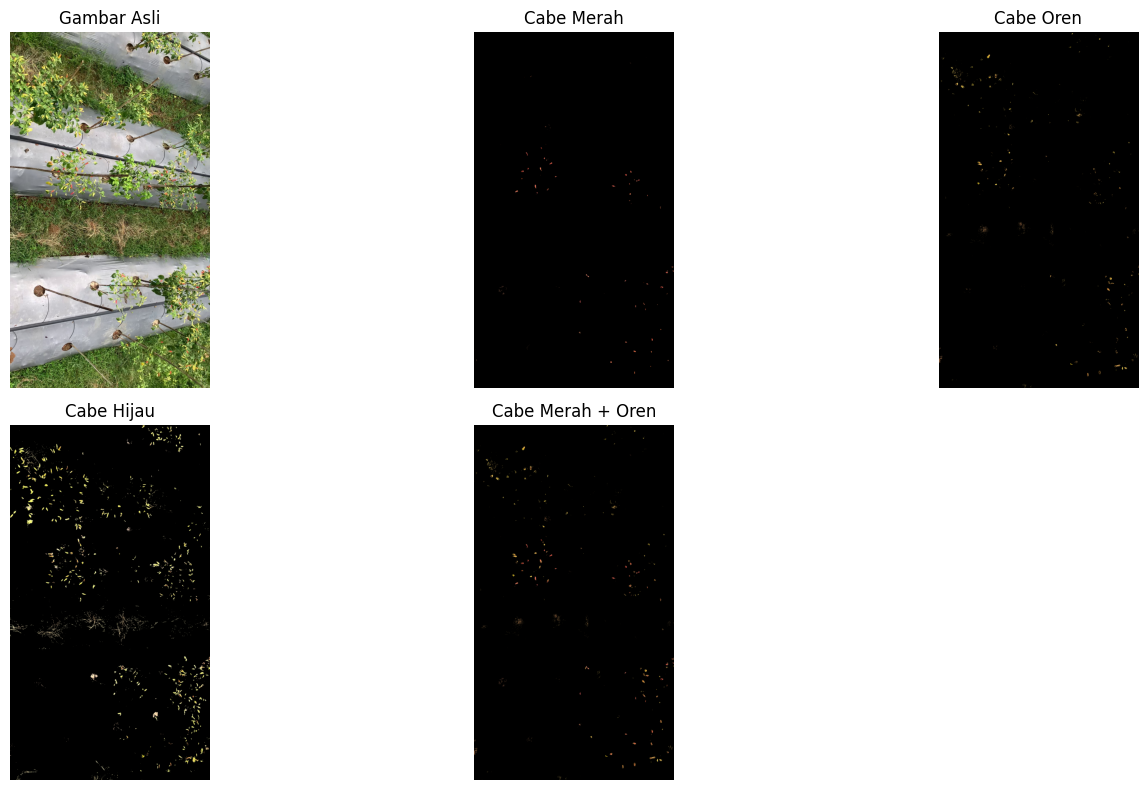

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load gambar
img = cv2.imread("frames3/frame3_2250.jpg")
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Daftar rentang HSV
ranges = {
    "cabe_merah": ([0, 120, 100], [10, 255, 255]),
    "cabe_oren": ([13, 130, 120], [25, 255, 255]),
    "cabe_hijau": ([10, 40, 200], [32, 255, 255]),
}

# Siapkan figure
plt.figure(figsize=(15, 8))

# Tampilkan gambar asli
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(2, 3, 1)
plt.imshow(img_rgb)
plt.title("Gambar Asli")
plt.axis('off')

# Segmentasi dan tampilkan masing-masing warna
masks = {}
for i, (label, (lower, upper)) in enumerate(ranges.items(), start=2):
    lower_np = np.array(lower, dtype=np.uint8)
    upper_np = np.array(upper, dtype=np.uint8)
    
    mask = cv2.inRange(img_hsv, lower_np, upper_np)
    masks[label] = mask  # simpan mask untuk digabung nanti
    
    result = cv2.bitwise_and(img, img, mask=mask)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 3, i)
    plt.imshow(result_rgb)
    plt.title(label.replace('_', ' ').title())
    plt.axis('off')

# Gabungkan cabe merah + oren
mask_merah_oren = cv2.bitwise_or(masks["cabe_merah"], masks["cabe_oren"])
result_merah_oren = cv2.bitwise_and(img, img, mask=mask_merah_oren)
result_merah_oren_rgb = cv2.cvtColor(result_merah_oren, cv2.COLOR_BGR2RGB)

plt.subplot(2, 3, 5)
plt.imshow(result_merah_oren_rgb)
plt.title("Cabe Merah + Oren")
plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
!pip install supervision

  Using cached defusedxml-0.7.1-py2.py3-none-any.whl.metadata (32 kB)
Using cached defusedxml-0.7.1-py2.py3-none-any.whl (25 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from inference import get_model
import supervision as sv
import cv2

# define the image url to use for inference
image_file = "tumbal.jpg"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
model = get_model(model_id="bener-100/3")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = model.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

ModuleNotFoundError: No module named 'inference'

In [17]:
from ultralytics import YOLO
import cv2
import numpy as np
from sort.sort import Sort

# ===== Load model YOLO baru untuk cabai =====
model_cabai = YOLO('bestsegbaru.pt')  # ganti path modelmu

# ===== Load video =====
cap = cv2.VideoCapture('shalmann/shalman/aman3.MOV')
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# ===== Output video =====
out = cv2.VideoWriter('output_cabai_sort_mov3.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (frame_width, frame_height))

# ===== Garis batas kanan dan variabel count =====
garis_kanan = ferame_width - 80
total_lewat = 0
sudah_dihitung = set()
track_history = {}

# ===== Inisialisasi SORT tracker =====
tracker = Sort()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # ==== Deteksi dengan YOLOv8 cabai ====
    results = model_cabai(frame, verbose=False)[0]
    detections = []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        if conf > 0.25:
            detections.append([x1, y1, x2, y2, conf])

    # ==== Tracking ====
    dets = np.array(detections) if detections else np.empty((0, 5))
    tracks = tracker.update(dets)

    # ==== Proses setiap track ====
    for track in tracks:
        x1, y1, x2, y2, track_id = track.astype(int)
        cx = int((x1 + x2) / 2)

        # Gambar box dan ID
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame, f'', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        # Hitung jika melewati garis kanan
        if track_id in track_history:
            prev_cx = track_history[track_id]
            if prev_cx < garis_kanan and cx >= garis_kanan and track_id not in sudah_dihitung:
                total_lewat += 1
                sudah_dihitung.add(track_id)
        track_history[track_id] = cx

    # ==== Gambar garis dan total ====
    cv2.line(frame, (garis_kanan, 0), (garis_kanan, frame_height), (0, 255, 0), 2)
    cv2.putText(frame, f"Cabai lewat: {total_lewat}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
from sort.sort import Sort

# Buka video drone
cap = cv2.VideoCapture('shalman-20250423T022115Z-001/shalman/aman3.MOV')

# Output video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter('frame3testv4kanankekiri.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (frame_width, frame_height))

# Garis batas untuk hitung
garis_y = frame_height - 0
garis_kiri = 50
garis_kanan = frame_width - 0
total_lewat = 0

# Inisialisasi SORT tracker
tracker = Sort()
sudah_dihitung = set()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Masking warna merah
    mask = (
        cv2.inRange(hsv, np.array([0, 120, 100]), np.array([10, 255, 255])) +
        cv2.inRange(hsv, np.array([13, 130, 120]), np.array([25, 255, 255])) +
        cv2.inRange(hsv, np.array([25, 130, 230]), np.array([38, 255, 255])) +
        cv2.inRange(hsv, np.array([28, 100, 240]), np.array([31, 255, 255]))

    )

    # Bersihkan noise
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    # Temukan kontur objek
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detections = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 20 < area < 1000:
            x, y, w, h = cv2.boundingRect(cnt)
            detections.append([x, y, x + w, y + h, 1.0])

    dets = np.array(detections) if detections else np.empty((0, 5))
    tracks = tracker.update(dets)

    for track in tracks:
        x1, y1, x2, y2, track_id = track.astype(int)
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        # Gambar bounding box dan titik tengah saja (tanpa ID)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.circle(frame, (cx, cy), 4, (255, 0, 0), -1)

        # Cek apakah objek sudah dihitung dan melewati salah satu garis
        if track_id not in sudah_dihitung:
            if cy > garis_y or cx < garis_kiri or cx > garis_kanan:
                total_lewat += 1
                sudah_dihitung.add(track_id)


    # Gambar garis batas
    cv2.line(frame, (0, garis_y), (frame_width, garis_y), (0, 255, 0), 2)
    cv2.line(frame, (garis_kiri, 0), (garis_kiri, frame_height), (255, 255, 0), 2)
    cv2.line(frame, (garis_kanan, 0), (garis_kanan, frame_height), (255, 255, 0), 2)

    # jumlah cabai yg lewar
    cv2.putText(frame, f"Cabai lewat: {total_lewat}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 0), 3)

    out.write(frame)

cap.release()
out.release()


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load gambar
img_path = "frames3/frame3_0744.jpg"
img = cv2.imread(img_path)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Definisikan rentang HSV berdasarkan tuning visual & contoh sebelumnya
ranges = {
    "cabe_merah": ([0, 120, 100], [10, 255, 255]),
    "cabe_oren": ([13, 130, 120], [25, 255, 255]),
    "cabe_hijau": ([25, 130, 230], [38, 255, 255]),
    "cabe_hijau2": ([28, 100, 240], [31, 255, 255]), # hijau terang hindari daun gelap
}

# Gabungkan semua mask
mask_total = np.zeros(img.shape[:2], dtype=np.uint8)

for lower, upper in ranges.values():
    lower_np = np.array(lower, dtype=np.uint8)
    upper_np = np.array(upper, dtype=np.uint8)
    mask = cv2.inRange(img_hsv, lower_np, upper_np)
    mask_total = cv2.bitwise_or(mask_total, mask)

# Filter area berdasarkan kontur
contours, _ = cv2.findContours(mask_total, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_mask = np.zeros_like(mask_total)

area_min = 20
area_max = 1000

valid_areas = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area_min < area < area_max:
        cv2.drawContours(filtered_mask, [cnt], -1, 255, thickness=cv2.FILLED)
        valid_areas.append(area)

# Segmentasi final diterapkan ke gambar asli
result_segmented = cv2.bitwise_and(img, img, mask=filtered_mask)
result_rgb = cv2.cvtColor(result_segmented, cv2.COLOR_BGR2RGB)

# Tampilkan hasil
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Gambar Asli")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_rgb)
plt.title("Segmentasi Cabai (Merah, Oren, Hijau)")
plt.axis('off')
plt.tight_layout()
plt.show(), len(valid_areas), np.mean(valid_areas) if valid_areas else 0


(None, 243, np.float64(75.95061728395062))

: 

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

input_folder = "datasetuji1"  # Folder berisi gambar cabai
output_dir = "datasetuji1/databaru2"   # Folder output dataset
img_dir = os.path.join(output_dir, "images")
label_dir = os.path.join(output_dir, "labels")
os.makedirs(img_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)


def segment_chili(frame):
    """Segmentasi cabai merah dan hijau terang dengan HSV"""
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # === Cabai Merah/Oranye ===
    lower_reds = [
        np.array([0, 120, 100]),
        np.array([13, 130, 120]),
    ]
    upper_reds = [
        np.array([10, 255, 255]),
        np.array([25, 255, 255])
    ]
    
    mask_red = np.zeros(frame.shape[:2], dtype=np.uint8)
    for lower, upper in zip(lower_reds, upper_reds):
        mask_red = cv2.bitwise_or(mask_red, cv2.inRange(hsv, lower, upper))

    # === Cabai Hijau Terang ===
    lower_green = [
        np.array([25, 130, 230]),
        np.array([28, 100, 240])
    ]

    upper_green = [
        np.array([38, 255, 255]),
        np.array([31, 255, 255])
    ]

    mask_green = np.zeros(frame.shape[:2], dtype=np.uint8)
    for lower, upper in zip(lower_green, upper_green):
        mask_green = cv2.bitwise_or(mask_green, cv2.inRange(hsv, lower, upper))


        # === Preprocessing Noise Filter ===
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel)
        mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel)

        mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
        mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)

        return mask_red, mask_green  # dikembalikan terpisah



def mask_to_polygons(mask, width, height):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 25 < area < 1000:  # Skip area kecil
            continue
            
        # Simplify kontur
        epsilon = 0.01 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        
        # Normalisasi koordinat
        polygon = approx.reshape(-1, 2)
        norm_poly = polygon / np.array([width, height])
        polygons.append(norm_poly.flatten().tolist())
    
    return polygons

# === Proses Semua Gambar ===
image_files = [f for f in os.listdir(input_folder) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for filename in tqdm(image_files, desc="Processing Images"):
    img_path = os.path.join(input_folder, filename)
    frame = cv2.imread(img_path)
    if frame is None:
        continue

    height, width = frame.shape[:2]

    # Dapatkan mask terpisah
    mask_red, mask_green = segment_chili(frame)

    # Konversi ke polygon
    red_polygons = mask_to_polygons(mask_red, width, height)
    green_polygons = mask_to_polygons(mask_green, width, height)

    if not red_polygons and not green_polygons:
        continue  # Skip jika tidak ada cabai

    # Simpan gambar
    img_name = os.path.splitext(filename)[0] + ".jpg"
    img_path_out = os.path.join(img_dir, img_name)
    cv2.imwrite(img_path_out, frame)

    # Simpan label
    label_name = os.path.splitext(filename)[0] + ".txt"
    label_path = os.path.join(label_dir, label_name)

    with open(label_path, "w") as f:
        for poly in red_polygons:
            line = "0 " + " ".join([f"{coord:.6f}" for coord in poly]) + "\n"
            f.write(line)
        for poly in green_polygons:
            line = "1 " + " ".join([f"{coord:.6f}" for coord in poly]) + "\n"
            f.write(line)

print(f"\n Dataset ada di folder: {output_dir}")
print(f"- Gambar: {img_dir}")
print(f"- Label: {label_dir}")

Processing Images: 100%|██████████| 272/272 [00:25<00:00, 10.62it/s]


 Dataset ada di folder: datasetuji1/databaru3
- Gambar: datasetuji1/databaru3\images
- Label: datasetuji1/databaru3\labels


In [ ]:
def segment_chili(frame):
    """Segmentasi cabai merah, oranye, hijau terang, dan hilangkan noise dari latar"""
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # ============ Filter latar belakang (tanah dan plastik mulsa) ============
    # Mask background (tanah dan plastik)
    background_mask = cv2.inRange(hsv, np.array([0, 0, 0]), np.array([180, 60, 255]))

    # ============ Mask cabai merah & oranye ============
    lower_reds = [
        np.array([0, 100, 100]),
        np.array([13, 100, 100]),
    ]
    upper_reds = [
        np.array([10, 255, 255]),
        np.array([25, 255, 255]),
    ]

    mask_red = np.zeros(frame.shape[:2], dtype=np.uint8)
    for lower, upper in zip(lower_reds, upper_reds):
        mask_red = cv2.bitwise_or(mask_red, cv2.inRange(hsv, lower, upper))

    # ============ Mask cabai hijau terang ============
    lower_greens = [
        np.array([28, 100, 200]),
        np.array([29, 110, 240]),
    ]
    upper_greens = [
        np.array([38, 255, 255]),
        np.array([35, 255, 255]),
    ]

    mask_green = np.zeros(frame.shape[:2], dtype=np.uint8)
    for lower, upper in zip(lower_greens, upper_greens):
        mask_green = cv2.bitwise_or(mask_green, cv2.inRange(hsv, lower, upper))

    # ============ Gabungkan dan bersihkan ============
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel)
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel)

    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)

    # Hilangkan noise dari background (tanah/mulsa)
    mask_red = cv2.bitwise_and(mask_red, cv2.bitwise_not(background_mask))
    mask_green = cv2.bitwise_and(mask_green, cv2.bitwise_not(background_mask))

    return mask_red, mask_green


Merah detected: 47
Merah detected: 3
Hijau detected: 97
Oranye detected: 150


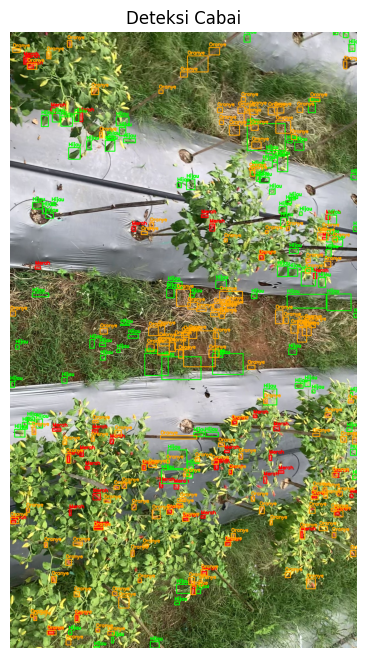

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load gambar
image = cv2.imread('frames3/frame3_0736.jpg')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Fungsi deteksi
def detect_color(hsv_img, lower, upper, color_name, draw_color, min_area=50, max_area=5000):
    mask = cv2.inRange(hsv_img, lower, upper)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(image, (x, y), (x+w, y+h), draw_color, 2)
            cv2.putText(image, color_name, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, draw_color, 2)
            count += 1
    print(f"{color_name} detected: {count}")

# Daftar warna HSV dan warna untuk bounding box
color_ranges = [
    ([0, 100, 100], [10, 255, 255], "Merah", (0, 0, 255)),
    ([160, 100, 100], [179, 255, 255], "Merah", (0, 0, 255)),
    ([35, 50, 50], [85, 255, 255], "Hijau", (0, 255, 0)),
    ([10, 100, 100], [25, 255, 255], "Oranye", (0, 165, 255)),
]

# Proses deteksi
for lower, upper, name, color in color_ranges:
    detect_color(hsv, np.array(lower), np.array(upper), name, color)

# Konversi BGR ke RGB untuk plt
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Tampilkan gambar
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.title("Deteksi Cabai")
plt.axis("off")
plt.show()


In [ ]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image_path = "t1.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Display HSV image for manual HSV sampling
plt.figure(figsize=(10, 5))
plt.imshow(image_hsv)
plt.title("HSV Image (for internal HSV inspection)")
plt.axis("off")
plt.show()

# Get representative HSV values for green chili (cabai hijau terang)
# We will define a mask manually based on expected bright green ranges to exclude leaves

# Define a general HSV range for green chili (light green, less saturated than leaf green)
lower_green_chili = np.array([35, 60, 60])
upper_green_chili = np.array([85, 255, 255])

# Create mask
mask_green_chili = cv2.inRange(image_hsv, lower_green_chili, upper_green_chili)
result_green_chili = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_green_chili)

# Display the mask and result
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(mask_green_chili, cmap='gray')
axs[0].set_title("Mask for Green Chili")
axs[0].axis("off")
axs[1].imshow(result_green_chili)
axs[1].set_title("Detected Green Chili (Filtered)")
axs[1].axis("off")
plt.tight_layout()
plt.show()

(lower_green_chili, upper_green_chili)


In [1]:
import cv2
import os
import matplotlib.pyplot as plt

# Path output hasil deteksi dan label
output_image_dir = 'datasetbr3/train/images'
output_label_dir = 'datasetbr3/train/labels'

# Ambil 3 file gambar dari folder output
image_files = [f for f in os.listdir(output_image_dir) if f.lower().endswith(('.jpg', '.png'))][:3]

# Tampilkan 3 gambar dengan anotasi
for fname in image_files:
    image_path = os.path.join(output_image_dir, fname)
    label_path = os.path.join(output_label_dir, os.path.splitext(fname)[0] + '.txt')

    img = cv2.imread(image_path)
    if img is None:
        continue

    h, w = img.shape[:2]

    # Baca label dan gambar kotak deteksi
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            class_id, x_center, y_center, box_w, box_h = map(float, parts)
            x_center *= w
            y_center *= h
            box_w *= w
            box_h *= h

            x1 = int(x_center - box_w / 2)
            y1 = int(y_center - box_h / 2)
            x2 = int(x_center + box_w / 2)
            y2 = int(y_center + box_h / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, "cabai", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

    # Konversi BGR ke RGB untuk matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(fname)
    plt.axis('off')
    plt.show()


ValueError: too many values to unpack (expected 5)